# One Value, One Noise
In this example, we examine the effect on the weights for a neural network trained on one important value and one noise value. This is useful as a means to see if the noise is completely tuned out or if another mechanism is in place.

## Imports

In [1]:
import math
import warnings

from typing import List, Dict
from statistics import mean, stdev
from random import randint

import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm

warnings.filterwarnings("ignore")

matplotlib.rcParams["animation.embed_limit"] = 2**128
matplotlib.rcParams["figure.dpi"] = 300

## Generating data

The data used for this notebook follows the equation $y = x$. To ensure replicable results as well as keeping the network's topology as simple as possible, the values for **x's** are randomly generated. There is the addition of a **noise** column that is purely there as a target for the network to tune out. 

In [2]:
SAMPLES = 5000

In [3]:
def generate_random_values():
    return [randint(0,50) * randint(0,50) for _ in range(SAMPLES)]

xs = generate_random_values()

ys = xs

noise = [randint(0,100) for _ in range(SAMPLES)]

data = {
    "xs": xs,
    "noise": noise, 
    "ys": ys
}

df = pd.DataFrame(data=data)
split = 500

train = df.iloc[split:]
test = df.iloc[:split]
train.shape, test.shape

((4500, 3), (500, 3))

In [4]:
X_train = train[["xs", "noise"]]
y_train = train["ys"]
X_test = test[["xs", "noise"]]
y_test = test["ys"]

In [5]:
def create_history(columns: int, nodes: int) -> Dict:
    return {i:{j: [] for j in range(nodes)} for i in range(columns)}

In [6]:
FIRST_LAYER = 1

In [7]:
history = create_history(len(X_train.columns), FIRST_LAYER)

## Defining Model

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(FIRST_LAYER, activation='relu'))
model.add(tf.keras.layers.Dense(units=1))
opt = Adam(0.01)
model.compile(optimizer=opt, loss="mean_squared_error")

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-12-04 21:43:03.998216: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-04 21:43:03.998360: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
for epoch in range(1, 501):
    print(f"RUNNING EPOCH {epoch}")
    hist = model.fit(X_train, y_train, epochs=1, batch_size=100)
    all_weights = model.layers[0].get_weights()[0].tolist()
    for weights in range(len(all_weights)):
        for weight in range(len(all_weights[weights])):
            history[weights][weight].append(all_weights[weights][weight])

RUNNING EPOCH 1


2022-12-04 21:43:04.093446: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-04 21:43:04.259177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 0s 3ms/step - loss: 1349837.8750
RUNNING EPOCH 2
45/45 [==============================] - 0s 4ms/step - loss: 811429.1875
RUNNING EPOCH 3
45/45 [==============================] - 0s 3ms/step - loss: 635879.0625
RUNNING EPOCH 4
45/45 [==============================] - 0s 3ms/step - loss: 372463.4062
RUNNING EPOCH 5
45/45 [==============================] - 0s 3ms/step - loss: 65137.5352
RUNNING EPOCH 6
45/45 [==============================] - 0s 3ms/step - loss: 1657.2563
RUNNING EPOCH 7
45/45 [==============================] - 0s 3ms/step - loss: 1119.7159
RUNNING EPOCH 8
45/45 [==============================] - 0s 4ms/step - loss: 997.2719
RUNNING EPOCH 9
45/45 [==============================] - 0s 3ms/step - loss: 884.7114
RUNNING EPOCH 10
45/45 [==============================] - 0s 3ms/step - loss: 776.4987
RUNNING EPOCH 11
45/45 [==============================] - 0s 3ms/step - loss: 675.3271
RUNNING EPOCH 12
45/45 [===========================

## Evaluating Model

In [10]:
res_xs = X_test["xs"].values.tolist()
res_noise = X_test["noise"].values.tolist()
res_pred = [
    round(i) for i in model.predict(X_test).flatten().tolist()
]
res = {
    "xs": res_xs,
    "noise": res_noise,
    "ys": y_test,
    "pred": res_pred
}

res = pd.DataFrame(res)
res

16/16 [==============================] - 0s 2ms/step


2022-12-04 21:44:30.600704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,xs,noise,ys,pred
0,66,24,66,66
1,21,19,21,21
2,792,2,792,792
3,432,25,432,432
4,658,99,658,658
...,...,...,...,...
495,672,27,672,672
496,1617,47,1617,1617
497,70,79,70,70
498,858,14,858,858


In [11]:
expected = list(res["ys"].values)
actual = list(res["pred"].values)
accuracies = []
for i in range(len(expected)):
    if expected[i] > actual[i]:
        accuracies.append((actual[i] / expected[i]) * 100)
    elif expected[i] < actual[i]:
        accuracies.append((expected[i] / actual[i]) * 100)
    else:
        accuracies.append(100)
print(f"The model is correct to {round(mean(accuracies), 5)}%")

The model is correct to 100%


## Colors
Setting some nice colors for our following plots

In [12]:
important = "#F3D250"
noise = "#F78888"
other = "#ECECEC"

## Splitting weights into groups

In [13]:
def get_groups(index: int, nodes: int) -> List:
    group = []
    for i in range(nodes):
        group.append(history[index][i])
    return group

In [14]:
xs = get_groups(0, 1)
noises = get_groups(0, 1)

## Box Plots

In [15]:
def generate_box_plot(
    ax,
    data: List,
    color: str,
    label: str,
    position_offset: int = 0,
    showfliers: bool = False
):
    ax.set_xlabel("Input Column and Node Number")
    ax.set_ylabel("Weight Values")
    color = {"color": color}
    ax.boxplot(
        data,
        positions=[i + position_offset for i in range(1,2)],
        boxprops=color,
        medianprops=color,
        whiskerprops=color,
        capprops=color,
        flierprops={"markeredgecolor": other},
        showfliers=showfliers,
        labels=[f"{label} {i}" for i in range(1, 2)]
    )

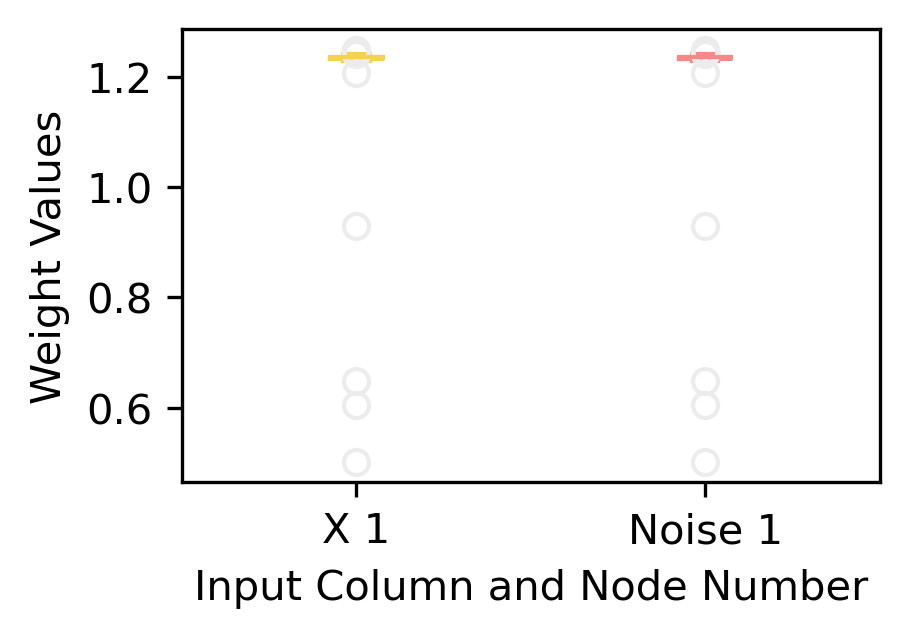

In [16]:
fig, ax = plt.subplots(figsize=(3,2))

generate_box_plot(
    ax,
    xs,
    important,
    "X",
    showfliers=True
)

generate_box_plot(ax,
    noises, noise, "Noise", 1, showfliers=True)

## Standard Deviation

In [17]:
data = {
    "x_one": xs[0],
    "noise_one": noises[0],
}

columns = [
    "x_one",
    "noise_one",
]


odf = pd.DataFrame(data)
odf.head(5)

,x_one,noise_one
0,0.649202,0.649202
1,0.502265,0.502265
2,0.605070,0.605070
3,0.929096,0.929096
4,1.207115,1.207115


In [18]:
std_df = odf.std().to_frame()
mean_df = odf.mean().to_frame()
std_df.columns = ["Std"]
mean_df.columns = ["Mean"]
merged_df = pd.merge(std_df, mean_df, left_index=True, right_index=True)

''

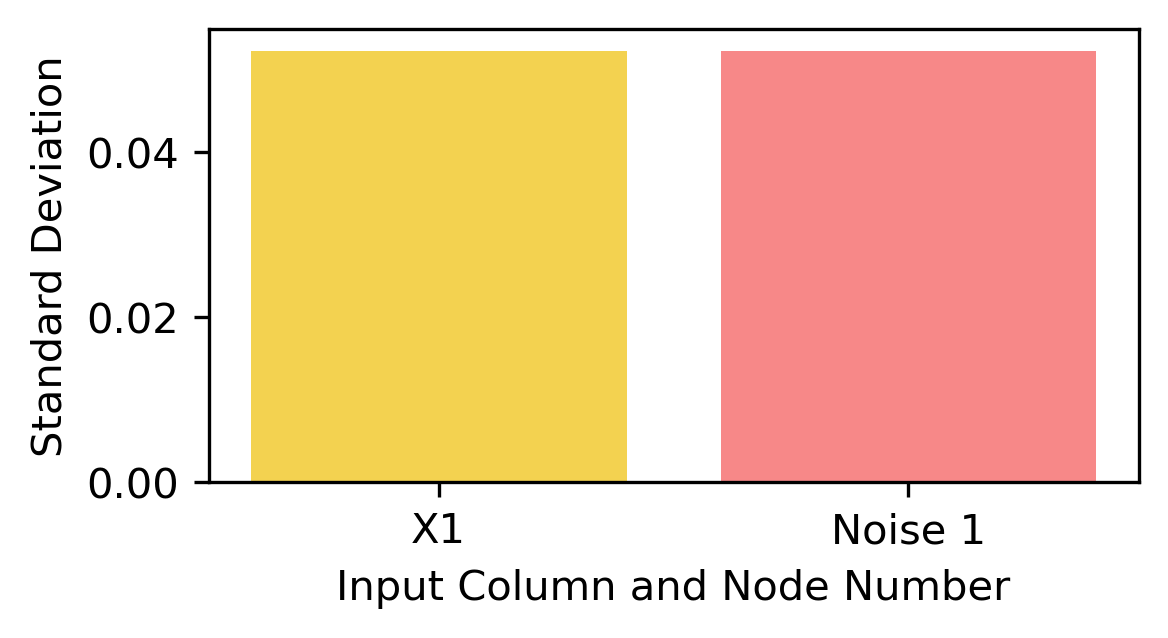

In [19]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.bar(
    [
        "X1",
        "Noise 1",
    ],
    [
        std_df["Std"].loc["x_one"],
        std_df["Std"].loc["noise_one"],
    ],
    color=[
        important,
        noise,
    ],
)
ax.set_xlabel("Input Column and Node Number")
ax.set_ylabel("Standard Deviation")
;

## Probability Densities

In [20]:
def get_group_by_node() -> List:
    return [history[0][0], history[1][0]]

In [21]:
group = get_group_by_node()

In [22]:
def plot_stds(group):
    _, ax = plt.subplots(figsize=(16,6))
    domain = np.linspace(-2,2,1000)
    means = [mean(group[0]), mean(group[1])]
    stds = [stdev(group[0]), stdev(group[1])]
    colors = [important, noise]

    for mu, std, color in zip(means, stds, colors):
        probs = norm.pdf(domain, mu, std)
        ax.plot(domain, probs, color=color)
        ax.set_xlabel("Weight")
        ax.set_ylabel("Probability Density")

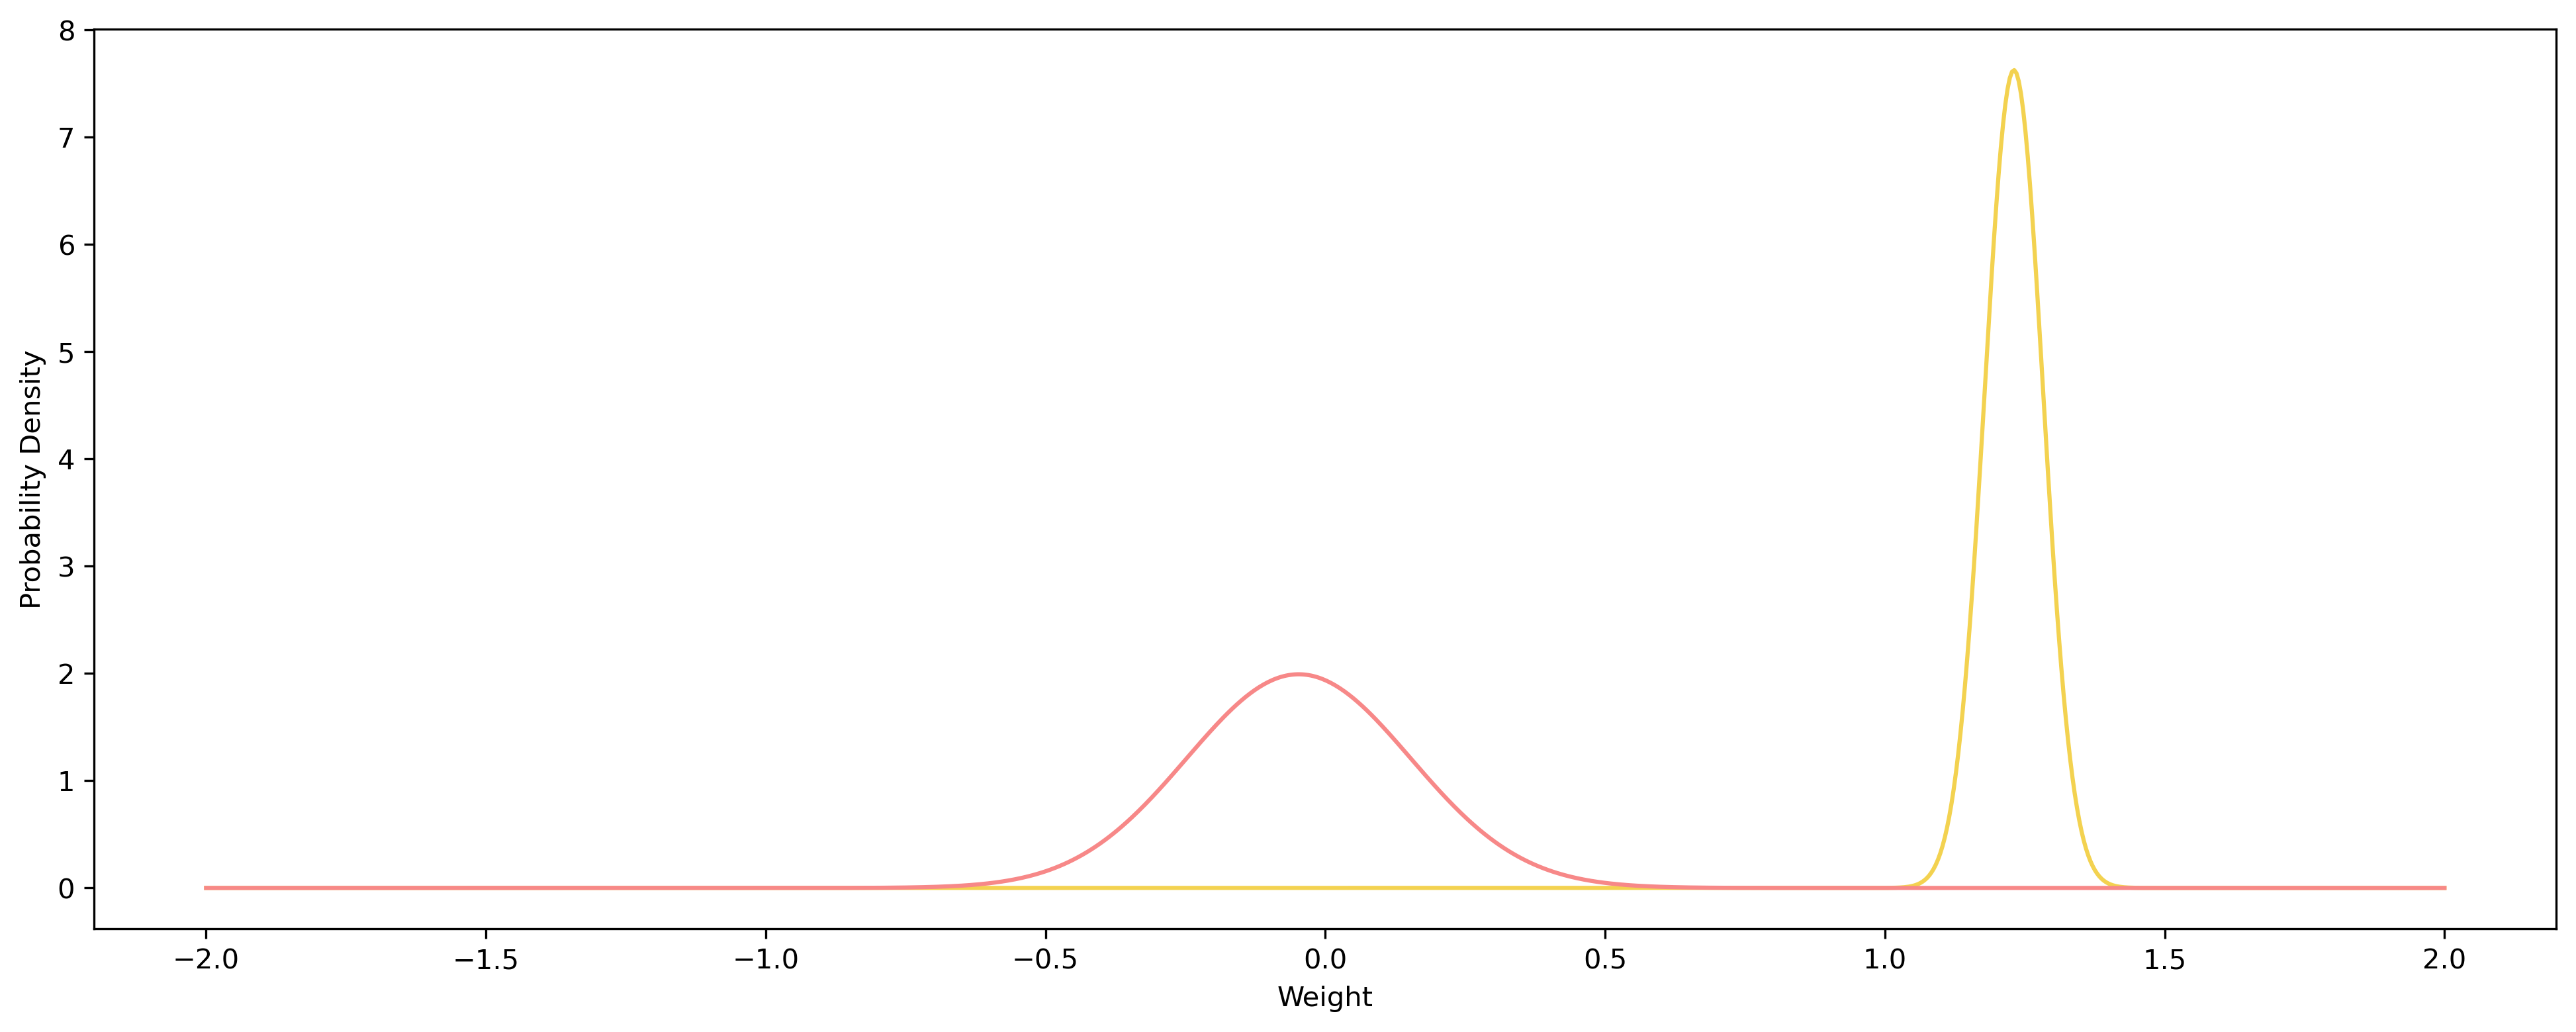

In [23]:
plot_stds(group)

## Evaluating the Probability Densities

In [24]:
def get_props(group):
    domain = np.linspace(-2,2,1000)
    means = [mean(group[0]), mean(group[1])]
    stds = [stdev(group[0]), stdev(group[1])]
    results = []
    for mu, std in zip(means, stds):
        values = []
        probs = norm.pdf(domain, mu, std)
        for prob in probs:
            if math.floor(prob) != 0:
                values.append(prob)
        results.append(values)
    return results

In [25]:
all_probs = [get_props(group)]

In [26]:
def barrage(all_probs, nodes: int):
    res = {
        i: {"len": 0, "max": 0, "sum": 0, "mean": 0, "stdev": 0} for i in range(nodes)
    }
    for probs in all_probs:
        for i, prob in enumerate(probs):
            res[i]["len"] += len(prob)
            res[i]["max"] += max(prob)
            res[i]["sum"] += sum(prob)
            res[i]["mean"] += mean(prob)
            res[i]["stdev"] += stdev(prob)
    return res

In [27]:
columns = ["xs", "noises"]

res = barrage(all_probs, len(columns))
for i in range(len(columns)):
    res[columns[i]] = res.pop(i)
df = pd.DataFrame(res)
df

,xs,noises
len,53.000000,118.000000
max,7.625071,1.992241
sum,239.133937,190.286369
mean,4.511961,1.612596
stdev,2.245451,0.313256


In [28]:
def plot_barrage(method: str):
    cdict = {"xs": important, "noises": noise}
    data = pd.Series(df.loc[method], df.columns).sort_values(ascending=True)
    cmap = [cdict[i] for i in list(data.index.values)]
    ax = data.plot.barh(width=0.8, figsize=(3, 1), color=cmap)
    ax.set_ylabel("Input")
    ax.set_xlabel(method.capitalize())

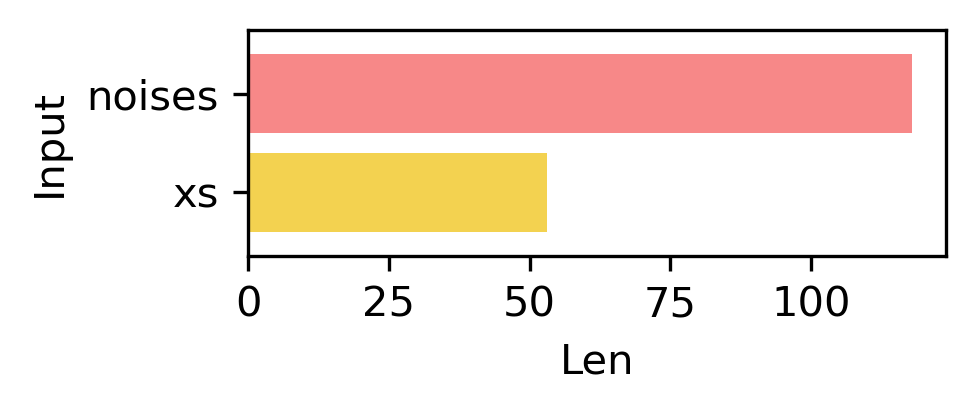

In [29]:
plot_barrage("len")

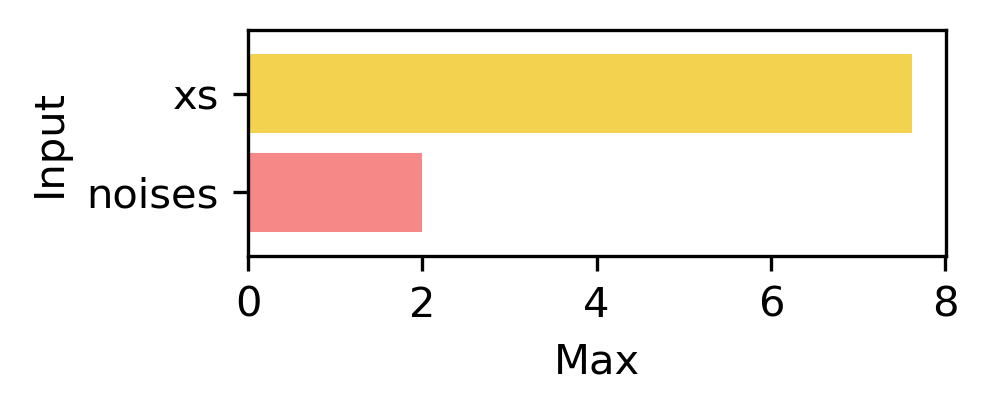

In [30]:
plot_barrage("max")

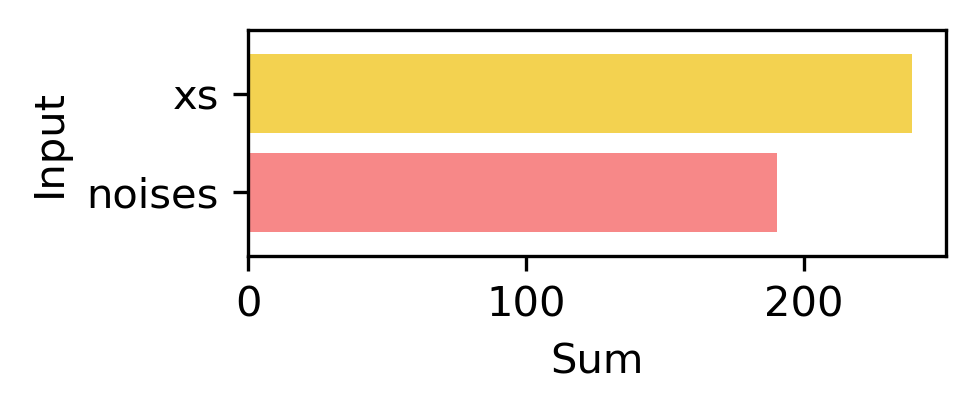

In [31]:
plot_barrage("sum")

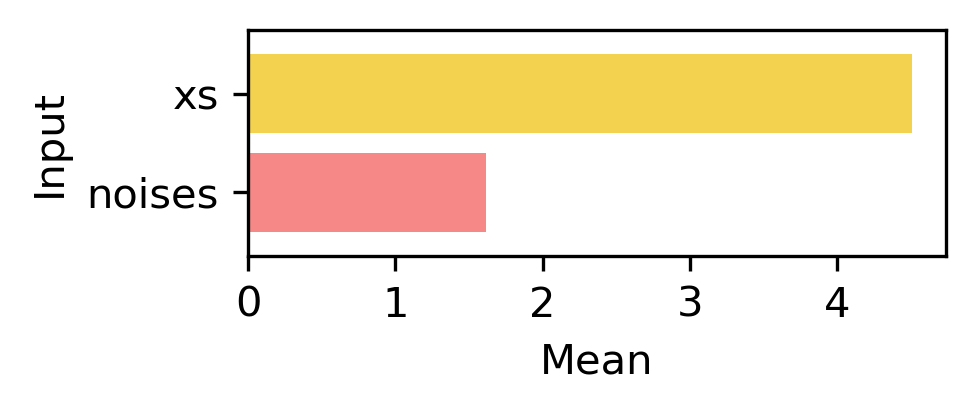

In [32]:
plot_barrage("mean")

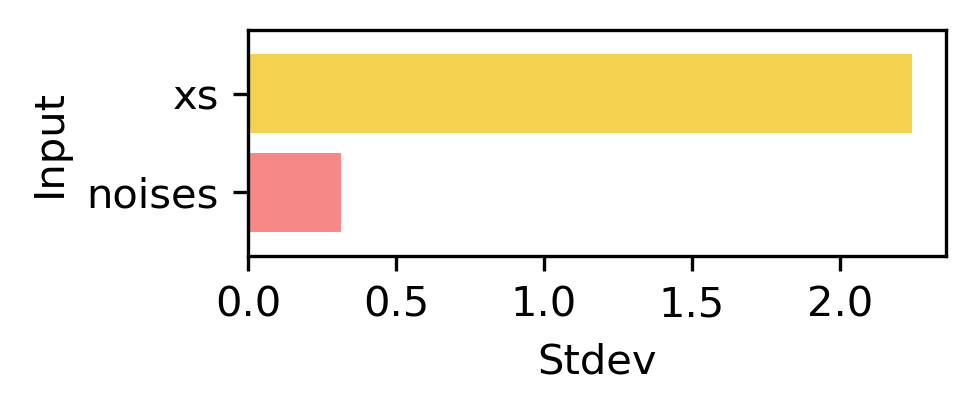

In [33]:
plot_barrage("stdev")